# Clustering & Anomaly Detection – Traffic G3

**Project**: Traffic Analysis for Howest Campus (CTAI)  
**Team**: Hadi, Rares, Hamzzah  
**Date**: January 2026

## Objective
This notebook addresses **requirement 3** of our project proposal:
1. **Clustering**: Group similar traffic patterns to understand typical behavior.
2. **Anomaly Detection**: Identify unusual traffic situations, such as unexpectedly few cyclists in good weather or abnormal nighttime patterns.

We focus on **cyclist traffic on both key streets near campus**: Sintmartenslatemlaan and Graaf Karel de Goedelaan.

**Approach**: Train a single combined model on both streets together, then interpret results per street.

We use:
- **KMeans clustering** to discover pattern groups
- **IsolationForest** to flag anomalies

## 1. Import Libraries

In [20]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
import pandas as pd


# Machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Display settings
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


## 2. Load and Explore Data

In [21]:
# Load the merged traffic and weather data
df = pd.read_csv('data/traffic_weather_merged.csv', parse_dates=['date'])

print(f"Dataset shape: {df.shape}")
print(f"\nDate range: {df['date'].min()} to {df['date'].max()}")
print(f"\nUnique streets: {df['street_name'].unique()}")
print("\n" + "="*60)
df.head()

Dataset shape: (2467, 33)

Date range: 2025-11-10 14:00:00+01:00 to 2026-01-06 08:00:00+01:00

Unique streets: ['Sintmartenslatemlaan' 'Graaf Karel de Goedelaan']



,instance_id,segment_id,date,interval,uptime,heavy,car,bike,pedestrian,night,heavy_lft,heavy_rgt,car_lft,car_rgt,bike_lft,bike_rgt,pedestrian_lft,pedestrian_rgt,night_lft,night_rgt,direction,car_speed_hist_0to70plus,car_speed_hist_0to120plus,timezone,v85,street_name,temperature_c,precipitation_mm,rain_mm,snowfall_cm,cloud_cover_pct,wind_speed_kmh,sunshine_duration_s
0,-1,9000008372,2025-11-21 09:00:00+01:00,hourly,0.499722,0.0,34.0,4.0,4.0,0.0,0.0,0.0,24.0,10.0,4.0,0.0,2.0,2.0,0.0,0.0,1,"[58.8235294118, 17.6470588235, 17.6470588235, ...","[52.9411764706, 5.8823529412, 5.8823529412, 11...",Europe/Paris,27.5,Sintmartenslatemlaan,0.2,0.0,0.0,0.0,100,12.2,6.59
1,-1,9000008372,2025-11-21 10:00:00+01:00,hourly,0.999444,0.0,39.0,11.0,6.0,0.0,0.0,0.0,20.0,19.0,8.0,3.0,1.0,5.0,0.0,0.0,1,"[61.5384615385, 17.9487179487, 10.2564102564, ...","[48.7179487179, 12.8205128205, 12.8205128205, ...",Europe/Paris,25.5,Sintmartenslatemlaan,0.8,0.0,0.0,0.0,100,13.4,3600.00
2,-1,9000008372,2025-11-21 11:00:00+01:00,hourly,0.999167,2.0,31.0,16.0,6.0,0.0,0.0,2.0,18.0,13.0,8.0,8.0,3.0,3.0,0.0,0.0,1,"[48.3870967742, 19.3548387097, 19.3548387097, ...","[45.1612903226, 3.2258064516, 6.4516129032, 12...",Europe/Paris,29.5,Sintmartenslatemlaan,1.3,0.0,0.0,0.0,100,11.0,672.91
3,-1,9000008372,2025-11-21 12:00:00+01:00,hourly,0.999722,1.0,47.0,30.0,20.0,0.0,1.0,0.0,26.0,21.0,10.0,20.0,9.0,11.0,0.0,0.0,1,"[48.9361702128, 21.2765957447, 12.7659574468, ...","[42.5531914894, 6.3829787234, 12.7659574468, 8...",Europe/Paris,32.5,Sintmartenslatemlaan,2.4,0.0,0.0,0.0,98,9.6,3600.00
4,-1,9000008372,2025-11-21 13:00:00+01:00,hourly,0.999167,1.0,26.0,19.0,36.0,0.0,1.0,0.0,13.0,13.0,9.0,10.0,17.0,19.0,0.0,0.0,1,"[53.8461538462, 11.5384615385, 7.6923076923, 1...","[50.0, 3.8461538462, 3.8461538462, 7.692307692...",Europe/Paris,35.5,Sintmartenslatemlaan,2.6,0.0,0.0,0.0,100,9.2,3600.00


In [22]:
# 2. Quick data quality check

print("Data info (columns + dtypes):")
print(df.dtypes)  # one line per column

print("\n" + "="*60)
print("Per-column missing values:\n")

missing = df.isnull().sum().to_frame(name="missing_count")
missing["missing_pct"] = (missing["missing_count"] / len(df) * 100).round(2)

print(missing)


Data info (columns + dtypes):
instance_id                                      int64
segment_id                                       int64
date                         datetime64[ns, UTC+01:00]
interval                                        object
uptime                                         float64
heavy                                          float64
car                                            float64
bike                                           float64
pedestrian                                     float64
night                                          float64
heavy_lft                                      float64
heavy_rgt                                      float64
car_lft                                        float64
car_rgt                                        float64
bike_lft                                       float64
bike_rgt                                       float64
pedestrian_lft                                 float64
pedestrian_rgt                     

## 3. Focus on Cyclists at Both Key Streets

We filter the data to analyze cyclist patterns on the two main streets near campus: **Sintmartenslatemlaan** and **Graaf Karel de Goedelaan**.

In [23]:
# Filter for both key streets near campus
df_two_streets = df[df['street_name'].isin([
    'Sintmartenslatemlaan',
    'Graaf Karel de Goedelaan'
])].copy()

print(f"Filtered dataset shape: {df_two_streets.shape}")
print(f"Date range: {df_two_streets['date'].min()} to {df_two_streets['date'].max()}")
print(f"\nData per street:")
print(df_two_streets.groupby('street_name').size())

# Feature engineering: extract time components
df_two_streets['hour'] = df_two_streets['date'].dt.hour
df_two_streets['dayofweek'] = df_two_streets['date'].dt.dayofweek  # 0=Monday, 6=Sunday
df_two_streets['is_weekend'] = (df_two_streets['dayofweek'] >= 5).astype(int)

# Encode street as numeric for the model
df_two_streets['street_id'] = df_two_streets['street_name'].astype('category').cat.codes

# Define target: cyclist count
df_two_streets['target_count'] = df_two_streets['bike']

print("\n✓ Feature engineering complete")
print(f"\nStreet encoding: {dict(enumerate(df_two_streets['street_name'].astype('category').cat.categories))}")
df_two_streets[['date', 'street_name', 'hour', 'dayofweek', 'is_weekend', 'target_count']].head(10)

Filtered dataset shape: (2467, 33)
Date range: 2025-11-10 14:00:00+01:00 to 2026-01-06 08:00:00+01:00

Data per street:
street_name
Graaf Karel de Goedelaan    1363
Sintmartenslatemlaan        1104
dtype: int64

✓ Feature engineering complete

Street encoding: {0: 'Graaf Karel de Goedelaan', 1: 'Sintmartenslatemlaan'}


,date,street_name,hour,dayofweek,is_weekend,target_count
0,2025-11-21 09:00:00+01:00,Sintmartenslatemlaan,9,4,0,4.0
1,2025-11-21 10:00:00+01:00,Sintmartenslatemlaan,10,4,0,11.0
2,2025-11-21 11:00:00+01:00,Sintmartenslatemlaan,11,4,0,16.0
3,2025-11-21 12:00:00+01:00,Sintmartenslatemlaan,12,4,0,30.0
4,2025-11-21 13:00:00+01:00,Sintmartenslatemlaan,13,4,0,19.0
5,2025-11-21 14:00:00+01:00,Sintmartenslatemlaan,14,4,0,21.0
6,2025-11-21 15:00:00+01:00,Sintmartenslatemlaan,15,4,0,15.0
7,2025-11-21 16:00:00+01:00,Sintmartenslatemlaan,16,4,0,27.0
8,2025-11-21 17:00:00+01:00,Sintmartenslatemlaan,17,4,0,0.0
9,2025-11-21 18:00:00+01:00,Sintmartenslatemlaan,18,4,0,0.0


## 4. Prepare Features for Clustering & Anomaly Detection

We select relevant features and handle missing values.

In [24]:
# Select features for clustering and anomaly detection
feature_cols = [
    'hour', 'dayofweek', 'is_weekend', 'street_id',
    'temperature_c', 'precipitation_mm', 'cloud_cover_pct',
    'target_count'
]


# Create feature matrix
df_features = df_two_streets[feature_cols].copy()

# Handle missing values (fill with 0 for simplicity)
df_features = df_features.fillna(0)

print(f"Feature matrix shape: {df_features.shape}")
print(f"\nMissing values after cleaning: {df_features.isnull().sum().sum()}")
print("\nFeature summary:")
df_features.describe()

Feature matrix shape: (2467, 8)

Missing values after cleaning: 0

Feature summary:


,hour,dayofweek,is_weekend,street_id,temperature_c,precipitation_mm,cloud_cover_pct,target_count
count,2467.000000,2467.000000,2467.000000,2467.000000,2467.000000,2467.000000,2467.000000,2467.000000
mean,11.501013,2.998784,0.291852,0.447507,5.578679,0.059505,73.574787,1.060544
std,6.930273,2.025086,0.454707,0.497338,4.341968,0.277754,37.575331,3.293120
min,0.000000,0.000000,0.000000,0.000000,-4.100000,0.000000,0.000000,0.000000
25%,5.000000,1.000000,0.000000,0.000000,2.500000,0.000000,42.000000,0.000000
50%,12.000000,3.000000,0.000000,0.000000,5.600000,0.000000,99.000000,0.000000
75%,18.000000,5.000000,1.000000,1.000000,8.900000,0.000000,100.000000,0.000000
max,23.000000,6.000000,1.000000,1.000000,15.600000,6.000000,100.000000,52.028905


In [25]:
# Standardize features for better clustering and anomaly detection
scaler = StandardScaler()
features_scaled = scaler.fit_transform(df_features)

print(f"✓ Features standardized")
print(f"Scaled feature matrix shape: {features_scaled.shape}")

✓ Features standardized
Scaled feature matrix shape: (2467, 8)


## 5. Clustering Analysis (KMeans)

**Goal**: Group similar traffic patterns to understand typical behavior across both streets.

We train a single KMeans model with 4 clusters on the combined data to identify distinct patterns such as:
- Rush hour with high cyclist traffic
- Quiet nighttime periods
- Weekend leisure patterns
- Weather-dependent variations

The model learns from both streets together, allowing us to compare patterns between locations.

In [26]:
# Fit KMeans with 4 clusters on combined data
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
df_two_streets['cluster'] = kmeans.fit_predict(features_scaled)

print(f"✓ KMeans clustering complete with {n_clusters} clusters")
print(f"\nOverall cluster distribution:")
print(df_two_streets['cluster'].value_counts().sort_index())
print(f"\nCluster distribution per street:")
print(df_two_streets.groupby(['street_name', 'cluster']).size().unstack(fill_value=0))

✓ KMeans clustering complete with 4 clusters

Overall cluster distribution:
cluster
0     127
1     708
2    1137
3     495
Name: count, dtype: int64

Cluster distribution per street:
cluster                     0    1    2    3
street_name                                 
Graaf Karel de Goedelaan   13  383  708  259
Sintmartenslatemlaan      114  325  429  236


In [27]:
# Analyze cluster characteristics - Overall
cluster_summary = df_two_streets.groupby('cluster').agg({
    'target_count': ['mean', 'std', 'count'],
    'hour': 'mean',
    'is_weekend': 'mean',
    'temperature_c': 'mean',
    'precipitation_mm': 'mean'
}).round(2)

cluster_summary.columns = ['_'.join(col).strip() for col in cluster_summary.columns]
cluster_summary = cluster_summary.rename(columns={
    'target_count_mean': 'Avg_Bikes',
    'target_count_std': 'Std_Bikes',
    'target_count_count': 'N_Hours',
    'hour_mean': 'Avg_Hour',
    'is_weekend_mean': 'Weekend_%',
    'temperature_c_mean': 'Avg_Temp_C',
    'precipitation_mm_mean': 'Avg_Rain_mm',
    'precipitation_mm_mean': 'Avg_Rain_mm'
})

print("Overall Cluster Characteristics:")
print("="*80)
print(cluster_summary)

# Analyze per street
print("\n\nCluster Characteristics Per Street:")
print("="*80)
cluster_per_street = df_two_streets.groupby(['street_name', 'cluster']).agg({
    'target_count': ['mean', 'count'],
    'hour': 'mean',
    'is_weekend': 'mean'
}).round(2)

cluster_per_street.columns = ['_'.join(col).strip() for col in cluster_per_street.columns]
cluster_per_street = cluster_per_street.rename(columns={
    'target_count_mean': 'Avg_Bikes',
    'target_count_count': 'N_Hours',
    'hour_mean': 'Avg_Hour',
    'is_weekend_mean': 'Weekend_%'
})
cluster_per_street

Overall Cluster Characteristics:
         Avg_Bikes  Std_Bikes  N_Hours  Avg_Hour  Weekend_%  Avg_Temp_C  \
cluster                                                                   
0            12.36       6.92      127     12.51       0.09        7.66   
1             0.48       1.37      708     11.48       1.00        5.25   
2             0.46       1.19     1137     11.42       0.00        7.12   
3             0.37       1.16      495     11.47       0.00        1.98   

         Avg_Rain_mm  
cluster               
0               0.03  
1               0.08  
2               0.07  
3               0.01  


Cluster Characteristics Per Street:


Avg_Bikes  N_Hours  Avg_Hour  Weekend_%
street_name              cluster                                         
Graaf Karel de Goedelaan 0            16.23       13     13.08       0.08
                         1             0.13      383     11.49       1.00
                         2             0.28      708     11.52       0.00
                         3             0.14      259     11.39       0.00
Sintmartenslatemlaan     0            11.92      114     12.45       0.10
                         1             0.90      325     11.47       1.00
                         2             0.75      429     11.24       0.00
                         3             0.63      236     11.56       0.00

### Visualize Clusters

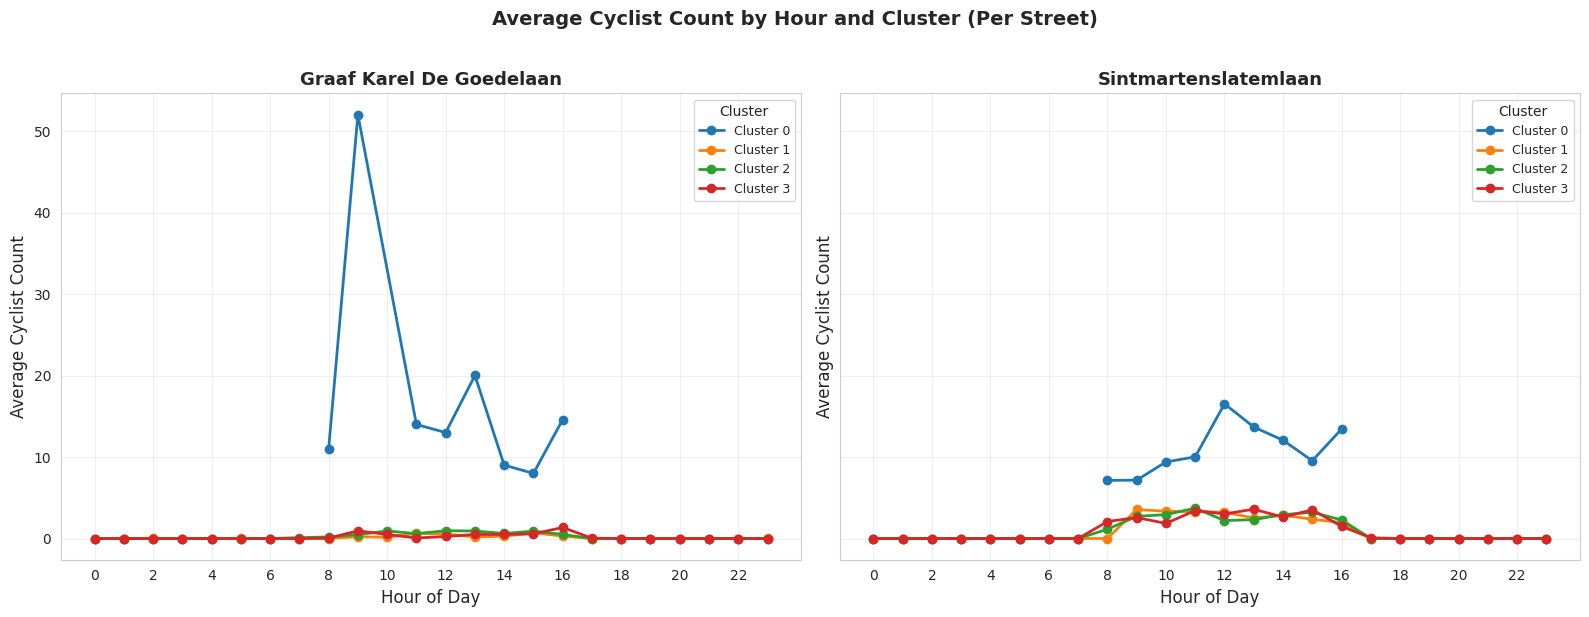

✓ Clusters show distinct temporal patterns across both streets


In [28]:
# Average cyclist count by hour for each cluster - separated by street
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

for idx, street in enumerate(['Graaf Karel de Goedelaan', 'Sintmartenslatemlaan']):
    street_data = df_two_streets[df_two_streets['street_name'] == street]
    cluster_hourly = street_data.groupby(['cluster', 'hour'])['target_count'].mean().reset_index()
    
    ax = axes[idx]
    for cluster in range(n_clusters):
        data = cluster_hourly[cluster_hourly['cluster'] == cluster]
        ax.plot(data['hour'], data['target_count'], marker='o', label=f'Cluster {cluster}', linewidth=2)
    
    ax.set_xlabel('Hour of Day', fontsize=12)
    ax.set_ylabel('Average Cyclist Count', fontsize=12)
    ax.set_title(f'{street.title()}', fontsize=13, fontweight='bold')
    ax.legend(title='Cluster', fontsize=9)
    ax.grid(alpha=0.3)
    ax.set_xticks(range(0, 24, 2))

plt.suptitle('Average Cyclist Count by Hour and Cluster (Per Street)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("✓ Clusters show distinct temporal patterns across both streets")

/tmp/ipykernel_825554/3690917952.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=street_data, x='cluster', y='target_count', palette='Set2', ax=ax)
/tmp/ipykernel_825554/3690917952.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=street_data, x='cluster', y='target_count', palette='Set2', ax=ax)


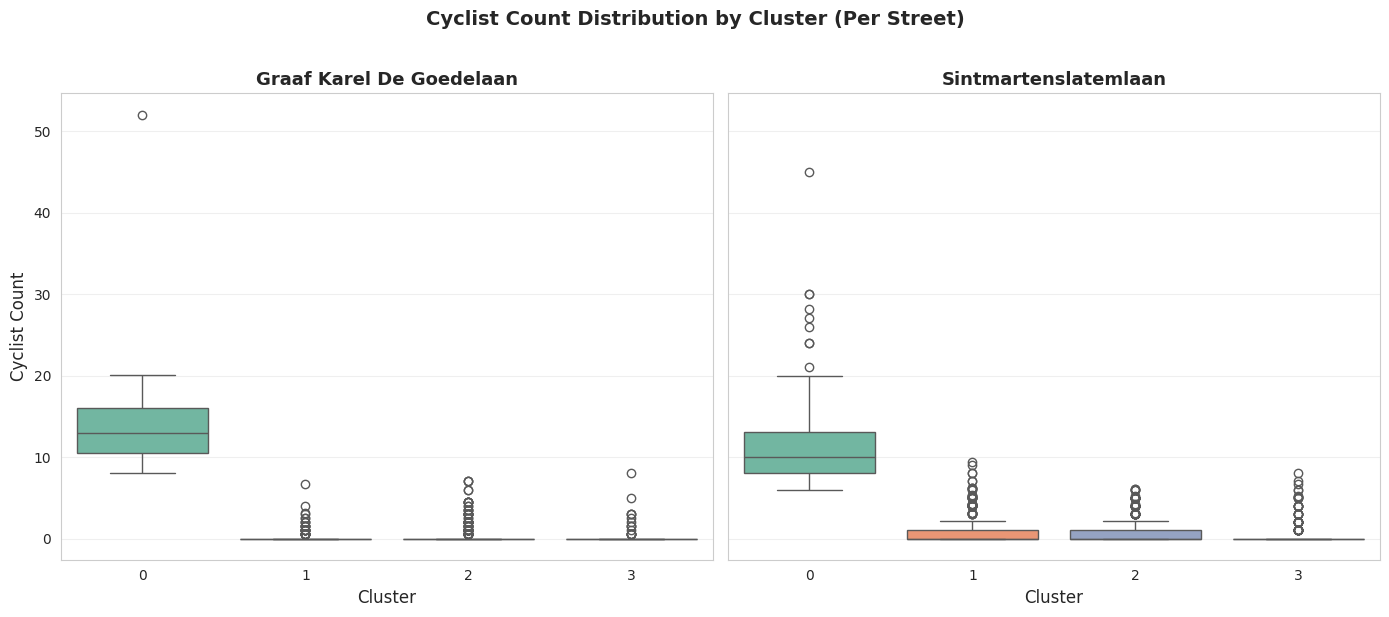

In [29]:
# Box plot: cyclist count distribution by cluster - faceted by street
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

for idx, street in enumerate(['Graaf Karel de Goedelaan', 'Sintmartenslatemlaan']):
    street_data = df_two_streets[df_two_streets['street_name'] == street]
    ax = axes[idx]
    
    import seaborn as sns
    sns.boxplot(data=street_data, x='cluster', y='target_count', palette='Set2', ax=ax)
    ax.set_xlabel('Cluster', fontsize=12)
    ax.set_ylabel('Cyclist Count', fontsize=12)
    ax.set_title(f'{street.title()}', fontsize=13, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)

plt.suptitle('Cyclist Count Distribution by Cluster (Per Street)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 6. Anomaly Detection (IsolationForest)

**Goal**: Identify unusual traffic situations that deviate from typical patterns across both streets.

We train a single IsolationForest model on the combined data to flag anomalies such as:
- Unexpectedly few cyclists during good weather
- Abnormal nighttime traffic
- Other irregular patterns

The model learns normal patterns from both streets, then we can examine anomalies per street.

In [30]:
# Train IsolationForest with 2% contamination rate on combined data
contamination_rate = 0.02
iso_forest = IsolationForest(contamination=contamination_rate, random_state=42)
anomaly_predictions = iso_forest.fit_predict(features_scaled)

# Convert predictions: -1 = anomaly, 1 = normal
df_two_streets['is_anomaly'] = (anomaly_predictions == -1)

n_anomalies = df_two_streets['is_anomaly'].sum()
print(f"✓ Anomaly detection complete")
print(f"\nOverall anomalies detected: {n_anomalies} ({n_anomalies/len(df_two_streets)*100:.2f}%)")
print(f"Normal observations: {(~df_two_streets['is_anomaly']).sum()}")

print("\nAnomalies per street:")
anomaly_per_street = df_two_streets.groupby('street_name')['is_anomaly'].agg(['sum', 'mean'])
anomaly_per_street.columns = ['Count', 'Rate']
anomaly_per_street['Rate'] = (anomaly_per_street['Rate'] * 100).round(2)
print(anomaly_per_street)

✓ Anomaly detection complete

Overall anomalies detected: 50 (2.03%)
Normal observations: 2417

Anomalies per street:
                          Count  Rate
street_name                          
Graaf Karel de Goedelaan     15  1.10
Sintmartenslatemlaan         35  3.17


### Top Anomalies

In [31]:
# Extract anomalies - sorted by LOW cyclist count (ascending)
anomalies = df_two_streets[df_two_streets['is_anomaly']].copy()
anomalies = anomalies.sort_values('target_count', ascending=True)  # Changed to ascending

# Select relevant columns for display
anomaly_cols = [
    'date', 'street_name', 'hour', 'target_count', 'temperature_c', 'precipitation_mm', 
    'cloud_cover_pct', 'is_weekend', 'cluster'
]

top_anomalies = anomalies[anomaly_cols].head(20)

print("Top 20 Anomalies (sorted by LOWEST cyclist count):")
print("="*100)
top_anomalies

Top 20 Anomalies (sorted by LOWEST cyclist count):


,date,street_name,hour,target_count,temperature_c,precipitation_mm,cloud_cover_pct,is_weekend,cluster
40,2025-11-23 01:00:00+01:00,Sintmartenslatemlaan,1,0.000000,-0.2,0.6,100,1,1
202,2025-11-29 19:00:00+01:00,Sintmartenslatemlaan,19,0.000000,10.0,1.8,100,1,1
203,2025-11-29 20:00:00+01:00,Sintmartenslatemlaan,20,0.000000,9.6,1.1,100,1,1
81,2025-11-24 18:00:00+01:00,Sintmartenslatemlaan,18,0.000000,5.6,6.0,100,0,2
392,2025-12-07 17:00:00+01:00,Sintmartenslatemlaan,17,0.000000,13.1,0.8,100,1,1
380,2025-12-07 05:00:00+01:00,Sintmartenslatemlaan,5,0.000000,8.6,3.6,100,1,1
1743,2025-12-07 05:00:00+01:00,Graaf Karel de Goedelaan,5,0.000000,8.6,3.6,100,1,1
1755,2025-12-07 17:00:00+01:00,Graaf Karel de Goedelaan,17,0.000000,13.1,0.8,100,1,1
1403,2025-11-23 01:00:00+01:00,Graaf Karel de Goedelaan,1,0.000000,-0.2,0.6,100,1,1
1444,2025-11-24 18:00:00+01:00,Graaf Karel de Goedelaan,18,0.000000,5.6,6.0,100,0,2


### Focus: Low Cyclist Count in Good Weather

This is particularly interesting for our project – identifying times when cycling conditions were favorable (no rain, reasonable temperature) but cyclist counts were unexpectedly low.

In [32]:
# Filter anomalies: good weather but low cyclist count
good_weather_anomalies = anomalies[
    (anomalies['precipitation_mm'] == 0) &  # No rain
    (anomalies['temperature_c'] >= 10) &    # Reasonable temperature
    (anomalies['temperature_c'] <= 25) &    # Not too hot
    (anomalies['target_count'] < anomalies['target_count'].median())  # Below median
].copy()

print(f"Anomalies with GOOD WEATHER but LOW cyclist count: {len(good_weather_anomalies)}")
print("="*100)
print("\nThese could indicate:")
print("- Special events or road closures")
print("- Holiday periods when campus is quiet")
print("- Data quality issues")
print("- Other external factors affecting cycling")

print("\nBreakdown per street:")
print(good_weather_anomalies.groupby('street_name').size())
print("\nTop:")
print("="*100)
good_weather_anomalies[anomaly_cols].head(15)

Anomalies with GOOD WEATHER but LOW cyclist count: 1

These could indicate:
- Special events or road closures
- Holiday periods when campus is quiet
- Data quality issues
- Other external factors affecting cycling

Breakdown per street:
street_name
Graaf Karel de Goedelaan    1
dtype: int64

Top:


,date,street_name,hour,target_count,temperature_c,precipitation_mm,cloud_cover_pct,is_weekend,cluster
1223,2025-11-15 13:00:00+01:00,Graaf Karel de Goedelaan,13,2.0,15.1,0.0,52,1,1


In [33]:
# Compute hourly medians per street for context
hourly_median = df_two_streets.groupby(['street_name', 'hour'])['target_count'].median()

# Map each anomaly to its expected median for that street+hour
good_weather_anomalies['hourly_median'] = good_weather_anomalies.set_index(['street_name', 'hour']).index.map(hourly_median)

# Calculate ratio: how far below typical is this anomaly?
good_weather_anomalies['ratio_to_median'] = (good_weather_anomalies['target_count'] / good_weather_anomalies['hourly_median']).round(2)

print("Good Weather Anomalies Compared to Street-Specific Hourly Medians:")
print("="*100)
print("Ratio < 1.0 means below typical for that street+hour")
print("="*100)

display_cols = anomaly_cols + ['hourly_median', 'ratio_to_median']
good_weather_anomalies[display_cols].head(15)

Good Weather Anomalies Compared to Street-Specific Hourly Medians:
Ratio < 1.0 means below typical for that street+hour


,date,street_name,hour,target_count,temperature_c,precipitation_mm,cloud_cover_pct,is_weekend,cluster,hourly_median,ratio_to_median
1223,2025-11-15 13:00:00+01:00,Graaf Karel de Goedelaan,13,2.0,15.1,0.0,52,1,1,0.0,inf


### Validate Anomalies Against Street-Specific Hourly Medians

To ensure these anomalies are truly unusual, we compare them against typical hourly cyclist counts for each street.

### Visualize Anomalies

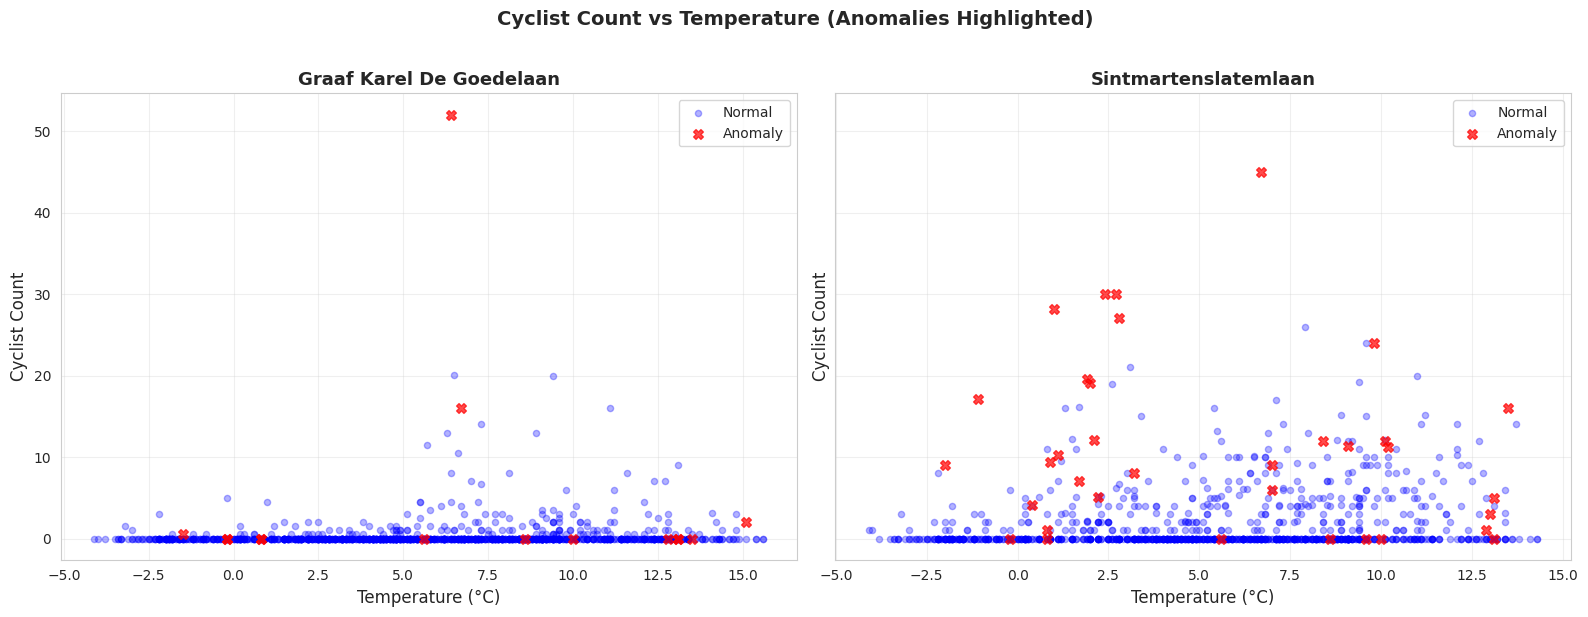

In [34]:
# Scatter plot: cyclist count vs temperature, highlighting anomalies - per street
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

for idx, street in enumerate(['Graaf Karel de Goedelaan', 'Sintmartenslatemlaan']):
    street_data = df_two_streets[df_two_streets['street_name'] == street]
    normal = street_data[~street_data['is_anomaly']]
    anomaly = street_data[street_data['is_anomaly']]
    
    ax = axes[idx]
    ax.scatter(normal['temperature_c'], normal['target_count'], 
               alpha=0.3, s=20, c='blue', label='Normal')
    ax.scatter(anomaly['temperature_c'], anomaly['target_count'], 
               alpha=0.7, s=50, c='red', marker='X', label='Anomaly')
    
    ax.set_xlabel('Temperature (°C)', fontsize=12)
    ax.set_ylabel('Cyclist Count', fontsize=12)
    ax.set_title(f'{street.title()}', fontsize=13, fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.3)

plt.suptitle('Cyclist Count vs Temperature (Anomalies Highlighted)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

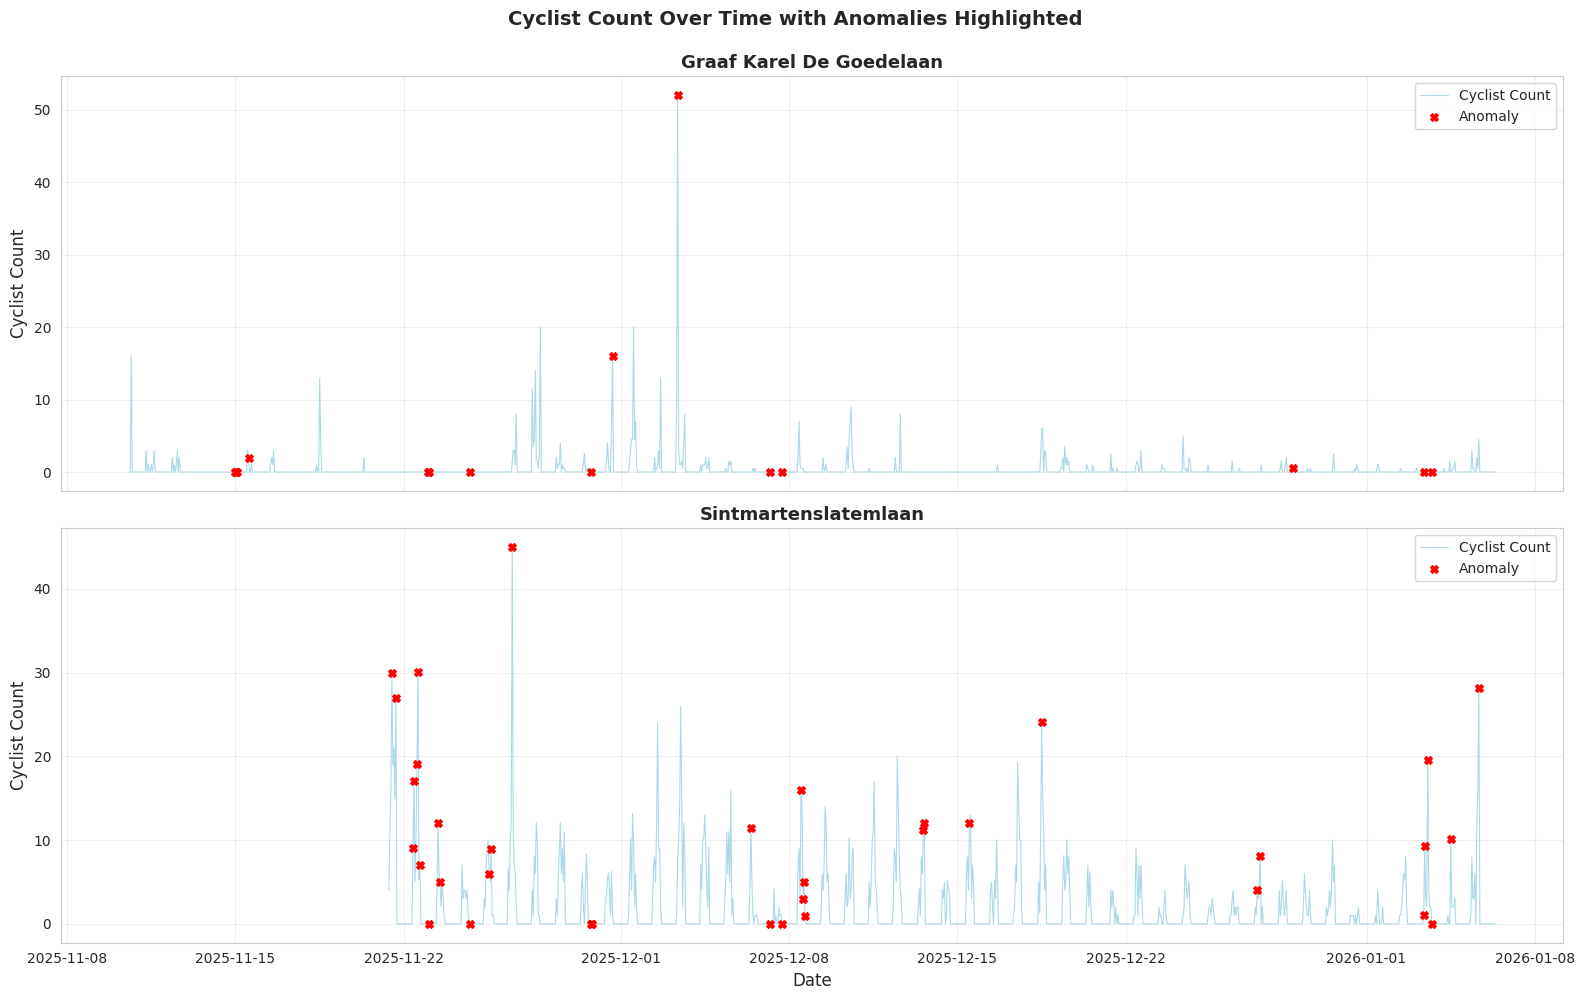

In [35]:
# Time series view: cyclist count over time with anomalies marked - per street
fig, axes = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

for idx, street in enumerate(['Graaf Karel de Goedelaan', 'Sintmartenslatemlaan']):
    street_data = df_two_streets[df_two_streets['street_name'] == street]
    anomaly_dates = street_data[street_data['is_anomaly']]
    
    ax = axes[idx]
    ax.plot(street_data['date'], street_data['target_count'], 
            color='lightblue', linewidth=0.8, label='Cyclist Count')
    ax.scatter(anomaly_dates['date'], anomaly_dates['target_count'], 
               color='red', s=30, marker='X', label='Anomaly', zorder=5)
    
    ax.set_ylabel('Cyclist Count', fontsize=12)
    ax.set_title(f'{street.title()}', fontsize=13, fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.3)

axes[1].set_xlabel('Date', fontsize=12)
plt.suptitle('Cyclist Count Over Time with Anomalies Highlighted', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

## 7. Interpretation & Project Alignment

### How This Satisfies Project Requirements

**Requirement: Group similar traffic patterns (Clustering)**
- We trained a **single combined KMeans model** on both streets together
- This identifies 4 distinct traffic patterns that apply across both locations
- We can then interpret clusters per street to understand:
  - How Sintmartenslatemlaan differs from Graaf Karel de Goedelaan
  - Whether rush hour patterns, weekend behavior, and weather effects are similar or different
- This combined approach is more robust than separate models and enables direct comparison

**Requirement: Detect anomalies**
- We trained a **single combined IsolationForest** on both streets
- The model flags unusual observations (~2% of data overall)
- Key findings include:
  - Hours with unexpectedly low cyclist counts despite good weather
  - Validated against **street-specific hourly medians** to ensure anomalies are truly unusual for each location
  - Abnormal patterns that may indicate events, holidays, or data issues
  - These anomalies help identify situations requiring further investigation

### Practical Value for Howest
1. **Safety**: Anomalies during expected high-traffic times could indicate infrastructure problems
2. **Planning**: Understanding cluster patterns helps optimize campus access timing for both streets
3. **Policy**: "Good weather, low cyclists" anomalies reveal opportunities to promote cycling
4. **Data Quality**: Extreme anomalies may flag sensor or data collection issues
5. **Comparative Insights**: The combined model allows direct comparison between the two streets' patterns

## 8. Summary Statistics

In [36]:
# Generate final summary
print("="*80)
print("CLUSTERING & ANOMALY DETECTION SUMMARY")
print("="*80)
print(f"\n📊 Dataset: Combined cyclist traffic from both streets")
print(f"   Streets: Sintmartenslatemlaan & Graaf Karel de Goedelaan")
print(f"   Total observations: {len(df_two_streets)}")
print(f"   Date range: {df_two_streets['date'].min().date()} to {df_two_streets['date'].max().date()}")

print(f"\n🔍 Clustering Results (Combined Model):")
print(f"   Number of clusters: {n_clusters}")
print(f"   Overall cluster distribution:")
for i in range(n_clusters):
    count = (df_two_streets['cluster'] == i).sum()
    pct = count / len(df_two_streets) * 100
    print(f"      Cluster {i}: {count} hours ({pct:.1f}%)")

print(f"\n   Per-street cluster distribution:")
for street in ['Graaf Karel de Goedelaan', 'Sintmartenslatemlaan']:
    street_data = df_two_streets[df_two_streets['street_name'] == street]
    print(f"\n   {street.title()}:")
    for i in range(n_clusters):
        count = (street_data['cluster'] == i).sum()
        pct = count / len(street_data) * 100
        print(f"      Cluster {i}: {count} hours ({pct:.1f}%)")

print(f"\n⚠️ Anomaly Detection Results (Combined Model):")
print(f"   Total anomalies: {n_anomalies} ({n_anomalies/len(df_two_streets)*100:.2f}%)")
print(f"   Per street:")
for street in ['Graaf Karel de Goedelaan', 'Sintmartenslatemlaan']:
    street_data = df_two_streets[df_two_streets['street_name'] == street]
    street_anomalies = street_data['is_anomaly'].sum()
    street_pct = street_anomalies / len(street_data) * 100
    print(f"      {street.title()}: {street_anomalies} ({street_pct:.2f}%)")

print(f"\n   Good weather + low cyclist anomalies: {len(good_weather_anomalies)}")
print(f"      (validated against street-specific hourly medians)")

print("="*80)

CLUSTERING & ANOMALY DETECTION SUMMARY

📊 Dataset: Combined cyclist traffic from both streets
   Streets: Sintmartenslatemlaan & Graaf Karel de Goedelaan
   Total observations: 2467
   Date range: 2025-11-10 to 2026-01-06

🔍 Clustering Results (Combined Model):
   Number of clusters: 4
   Overall cluster distribution:
      Cluster 0: 127 hours (5.1%)
      Cluster 1: 708 hours (28.7%)
      Cluster 2: 1137 hours (46.1%)
      Cluster 3: 495 hours (20.1%)

   Per-street cluster distribution:

   Graaf Karel De Goedelaan:
      Cluster 0: 13 hours (1.0%)
      Cluster 1: 383 hours (28.1%)
      Cluster 2: 708 hours (51.9%)
      Cluster 3: 259 hours (19.0%)

   Sintmartenslatemlaan:
      Cluster 0: 114 hours (10.3%)
      Cluster 1: 325 hours (29.4%)
      Cluster 2: 429 hours (38.9%)
      Cluster 3: 236 hours (21.4%)

⚠️ Anomaly Detection Results (Combined Model):
   Total anomalies: 50 (2.03%)
   Per street:
      Graaf Karel De Goedelaan: 15 (1.10%)
      Sintmartenslatemlaan: 35 (

Cluster 0 – peak cyclist traffic: daytime / rush‑hour periods with clearly higher cyclist counts on both streets.

Clusters 1–3 – quiet or off‑peak regimes: hours with very few cyclists, often at night, early morning, or under less favorable conditions.


In [37]:
# Export clustering models and results for dashboard
import joblib
import os

# Create models directory if it doesn't exist
os.makedirs("../models", exist_ok=True)

# Export clustering models
joblib.dump(kmeans, "../models/kmeans_model.pkl")
joblib.dump(iso_forest, "../models/isolation_forest_model.pkl")
joblib.dump(scaler, "../models/scaler_clustering.pkl")

# Export feature columns and other metadata for clustering
clustering_metadata = {
    'feature_cols': feature_cols,
    'n_clusters': n_clusters,
    'contamination_rate': contamination_rate,
    'street_encoding': dict(enumerate(df_two_streets['street_name'].astype('category').cat.categories))
}
joblib.dump(clustering_metadata, "../models/clustering_metadata.pkl")

# Export the processed clustering data with results
df_clustering_results = df_two_streets.copy()
df_clustering_results.to_parquet("../models/clustering_results.parquet")

print("✅ Exported clustering models and data to models/ directory")
print(f"📊 Clustering models: KMeans ({n_clusters} clusters), IsolationForest ({contamination_rate} contamination)")
print(f"📈 Results saved for {len(df_two_streets)} observations")
print(f"🎯 Anomalies detected: {df_two_streets['is_anomaly'].sum()} ({df_two_streets['is_anomaly'].sum()/len(df_two_streets)*100:.2f}%)")

✅ Exported clustering models and data to models/ directory
📊 Clustering models: KMeans (4 clusters), IsolationForest (0.02 contamination)
📈 Results saved for 2467 observations
🎯 Anomalies detected: 50 (2.03%)
